# Time-series analysis on air polution data

We look at four years of data for PM10 particles measured in different locations in Skopje. The data proves to be of heteroskedastic nature, that is, the variance is much higher in the winter. We also observe yearly periodicity and fit a hierachical model to describe the data.

The data was downloaded from the official Environment Ministry [web site](http://air.moepp.gov.mk/?page_id=175).

In [1]:
from datetime import datetime, date, timedelta
 
import numpy as np
import pandas as pd
import pymc as pm
import pymc.sampling_jax
import aesara.tensor as tt
import arviz as az
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

plt.style.use('seaborn-whitegrid')
plt.rcParams.update({'figure.figsize': [8, 5], 'figure.dpi': 95, 'font.size': 13})

/usr/local/lib/python3.9/site-packages/pymc/sampling_jax.py:36: UserWarning: This module is experimental.
  warnings.warn("This module is experimental.")


### Loading the data

In [2]:
data = pd.read_csv('skopje_pm10.csv', date_parser=True)

# skip inpersistant locations
data = data[~data.place.isin(['Mobile', 'MobileGP'])]

data = data.assign(time = data.time.map(lambda ts: datetime.strptime(ts, '%Y-%m-%d')))

data = data.assign(
    week = np.floor((data.time - data.time.min()).dt.days / 7).astype('int'),
    month = data.time.dt.month - 1,
    place_i = data.place.astype('category').cat.codes,
    doy = data.time.dt.dayofyear - 1,
    woy = np.floor((data.time.dt.dayofyear - 1) / 7).astype('int'),
)

data.sample(5)

,place,time,pm10,week,month,place_i,doy,woy
15802,Rektorat,2013-11-28,46.5387,19,10,5,331,47
4153,GaziBaba,2017-09-08,32.0358,216,8,1,250,35
1419,Centar,2017-10-11,37.7017,221,9,0,283,40
10809,Lisice,2020-08-08,22.6161,368,7,3,220,31
1913,Centar,2019-04-15,14.5811,299,3,0,104,14


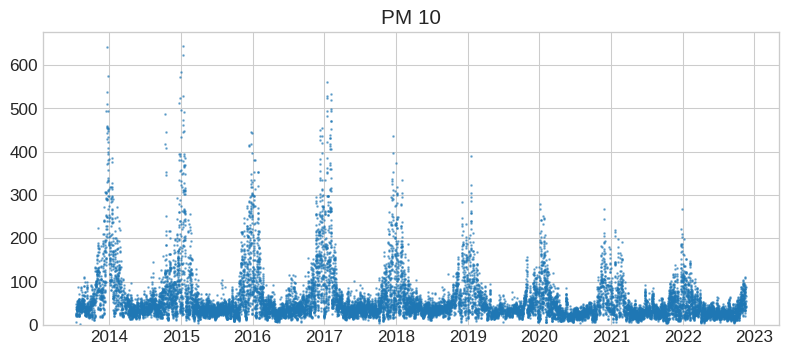

In [3]:
plt.figure(figsize=(10, 4))
plt.scatter(data.time, data.pm10, marker='.', s=4, alpha=.5, color='C0')
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y'))
plt.gca().set(title='PM 10', ylim=(0, None))
None

## Model

We are fitting a three-component model using the slow trend $a$, the monthly periodicity $s$ and the impact of the location of that measurment station, $l$, in the log-scale:

$$ \log \mu_i = a_{w_i} + s_{v_i} + l_{p_i} $$


where $w_i$, $v_i$ and $p_i$ are the overall week index, the week-of-year index and the location index at that particular data point.

The trend is treated as a gaussian random walk with a fixed drift $b$:

$$ a_w \sim \mathcal{N}(a_{w-1} + b, 0.005^2) $$

$$ b \sim \mathcal N(0, 0.005^2)  $$

The in-year periodicity is modeled as an inverse Fourier transform with a period 53 (maximum possible number of weeks in a year)  and order of 5:

$$ s_d = \sum_{k=1}^{5} \big(  \
  S_{k-1} \sin \frac{2 \pi k d}{53} + C_{k-1} \cos \frac{2 \pi k d}{53}  \
\big) $$

where the coefficients are given the following priors:

$$ S_k \sim \mathcal{N}(0, \frac{1}{2}) $$

$$ C_k \sim \mathcal{N}(0, \frac{1}{2}) $$

Finally, the location is treated as a category with partial pooling:
    
$$ l_p \sim \mathcal{N}(0, \kappa) $$

$$ \kappa \sim \text{Exponential}(2) $$

For the likelihood of the observations we use log-normal:

$$ \text{observed}_i \sim \text{Lognormal}(\log{\mu_i}, \rho) $$

$$ \rho \sim \text{Half-Normal}(1) $$

In [4]:
n_places = data.place_i.nunique()
n_weeks = int(data.week.max() + 1)
ft_order = 5

with pm.Model() as m1:
    # trend with fixed linear drift
    b = pm.Deterministic('b', 0.005 * pm.Normal('_b', 0, 1))
    a = pm.GaussianRandomWalk(
        'a', mu=b, sigma=0.005,
        init_dist=pm.Normal.dist(0, 0.5),
        shape=n_weeks)

    # location
    kappa = pm.Exponential('kappa', 1/0.5)
    l = pm.Normal('l', 0, kappa, shape=n_places)

    # monthly seasonality
    Sk = pm.Normal('Sk', 0, 0.5, shape=ft_order)
    Ck = pm.Normal('Ck', 0, 0.5, shape=ft_order)

    s = 0
    phi_k = np.array([
        2 * np.pi * k * np.arange(0, 53) / 53
        for k in range(1, ft_order+1)
    ])

    sin_s = tt.dot(Sk, np.sin(phi_k))
    cos_s = tt.dot(Ck, np.cos(phi_k))

    s = pm.Deterministic('s', sin_s + cos_s)

    # pointwise
    mu_i = (
        4
        + a[data.week.values]
        + l[data.place_i.values]
        + s[data.woy.values]
    )

    # likelihood
    rho = pm.Exponential('rho', 1)
    pm.Lognormal('obs', mu_i, rho, observed=data.pm10.values)

    # computed quantities
    pm.Deterministic('trend', tt.exp(4 + a + tt.mean(s)))
    pm.Deterministic('seasonal_factor', tt.exp(s - tt.mean(s)))

    m1.trace = pm.sampling_jax.sample_numpyro_nuts(
        5000, tune=5000, chains=2, 
        idata_kwargs=dict(log_likelihood=False), 
    )

Compiling...


Compilation time =  0:00:13.936761
Sampling...


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Sampling time =  0:15:09.122117
Transforming variables...
Transformation time =  0:00:01.447112


In [5]:
az.summary(m1.trace, var_names=['b', 'kappa', 'rho'], round_to=4)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b,-0.0010,0.0002,-0.0014,-0.0005,0.000,0.0000,15657.0636,7676.8836,1.0001
kappa,0.1741,0.0815,0.0720,0.3125,0.009,0.0064,114.4973,161.0309,1.0200
rho,0.5126,0.0028,0.5073,0.5176,0.000,0.0000,17451.8239,7003.7357,1.0002


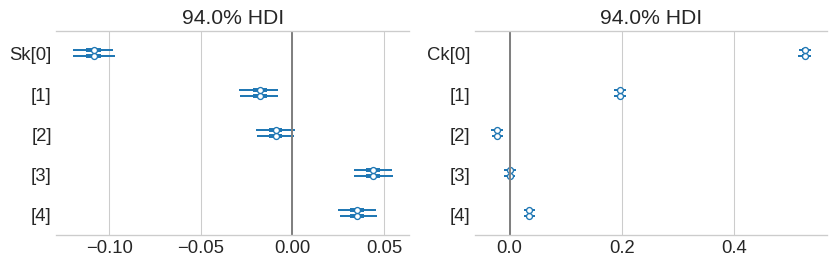

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(9, 3))
az.plot_forest(m1.trace, var_names=['Sk'], ax=axes[0])
az.plot_forest(m1.trace, var_names=['Ck'], ax=axes[1])
axes[0].axvline(0, color='gray')
axes[1].axvline(0, color='gray')
fig.tight_layout()
None

## Conclusions

### Estimate

In [7]:
trd = az.extract_dataset(m1.trace.posterior)

/tmp/ipykernel_133/1892996520.py:1: FutureWarning: extract_dataset has been deprecated, please use extract
  trd = az.extract_dataset(m1.trace.posterior)


/tmp/ipykernel_133/630595675.py:7: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  tmp = az.hdi(


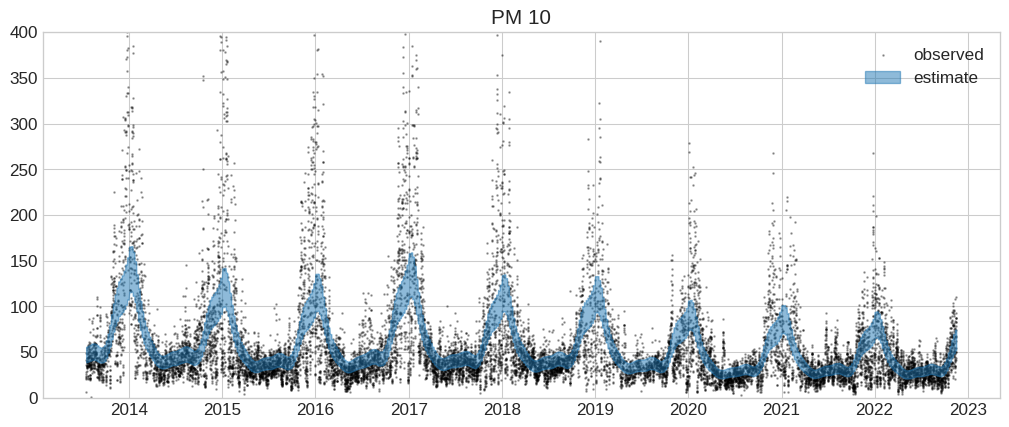

In [8]:
plt.figure(figsize=(13, 5))

plt.scatter(data.time, data.pm10,
            marker='.', s=4, color='k', label='observed', alpha=.3)

tmp_dates = data[['time', 'week', 'woy']].drop_duplicates().sort_values('time')
tmp = az.hdi(
    np.exp(
        4
        + trd.a.to_numpy()[tmp_dates.week]
        + trd.s.to_numpy()[tmp_dates.woy]
        + trd.rho.to_numpy().reshape(1, -1) ** 2 / 2
    ).T,
).T
plt.fill_between(tmp_dates['time'], tmp[0], tmp[1],
                 color='C0', label='estimate', alpha=.5)

plt.gca().xaxis.set_major_formatter(DateFormatter('%Y'))
plt.gca().set(title='PM 10', ylim=(0, 400))
plt.legend()
None

### Location

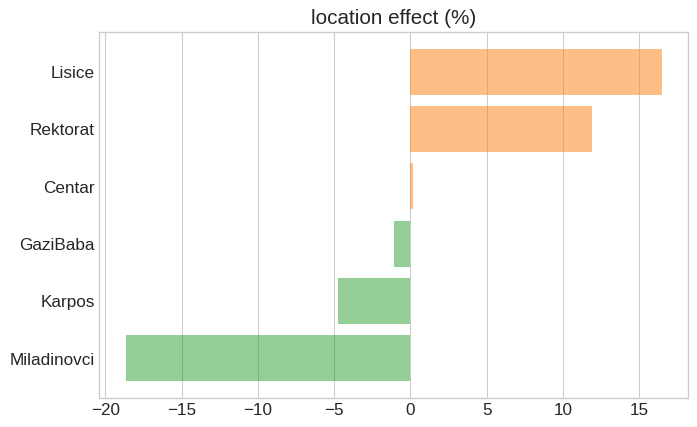

In [9]:
tmp = data[['place', 'place_i']].drop_duplicates().set_index('place_i').place.sort_index()

tmp = pd.Series(np.exp(trd.l).mean(axis=1), index=tmp).sort_values()
plt.barh(tmp.index, (tmp - 1) * 100,
         color=tmp.map(lambda x: 'C1' if x > 1 else 'C2'),
         alpha=.5)
plt.gca().set(title='location effect (%)', ylabel='')
plt.grid(axis='y')
None

### Trend and seasonal 

/tmp/ipykernel_133/1078699553.py:3: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  tmp = az.hdi(trd.trend.to_numpy().T).T


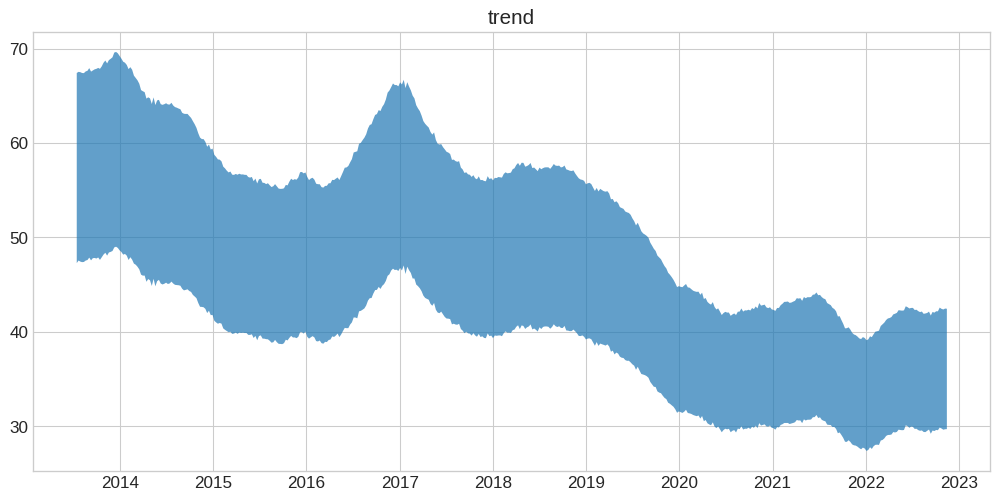

In [10]:
plt.figure(figsize=(13, 6))

tmp = az.hdi(trd.trend.to_numpy().T).T
plt.fill_between(
    data.groupby('week').time.min(), tmp[0], tmp[1],
    alpha=.7, label='trend'
)

plt.gca().xaxis.set_major_formatter(DateFormatter('%Y'))
plt.gca().set(title='trend')
None

/tmp/ipykernel_133/2449646768.py:6: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  tmp = az.hdi((tmp[1:] / tmp[:-1] - 1).T)


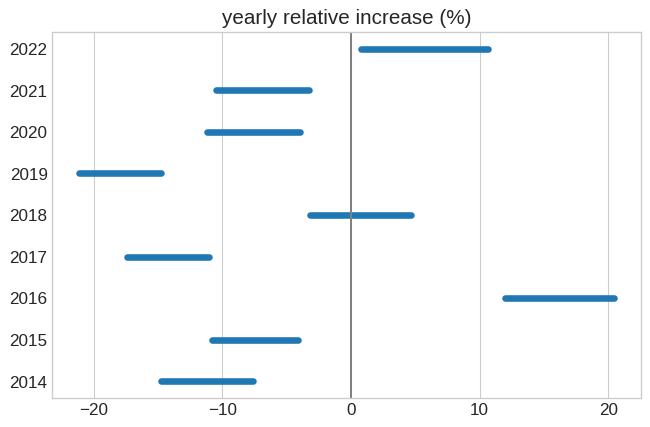

In [11]:
plt.figure(figsize=(8, 5))
tmp_dates = data[['time', 'week', 'woy']].drop_duplicates().sort_values('time')
tmp_dates = tmp_dates[(tmp_dates.time.dt.month == 11) & (tmp_dates.time.dt.day == 15)]

tmp = trd.trend.to_numpy()[tmp_dates.week.values]
tmp = az.hdi((tmp[1:] / tmp[:-1] - 1).T)

for i, t in enumerate(tmp_dates['time'].iloc[1:].values):
    y = pd.to_datetime(t).year
    plt.plot(tmp[i] * 100, (y, y), linewidth=5, color='C0')

plt.axvline(0, color='gray')
plt.gca().set(title='yearly relative increase (%)')
plt.grid(axis='y')
None

/tmp/ipykernel_133/420281356.py:3: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  tmp = (az.hdi(trd.seasonal_factor.to_numpy().T).T - 1)*100


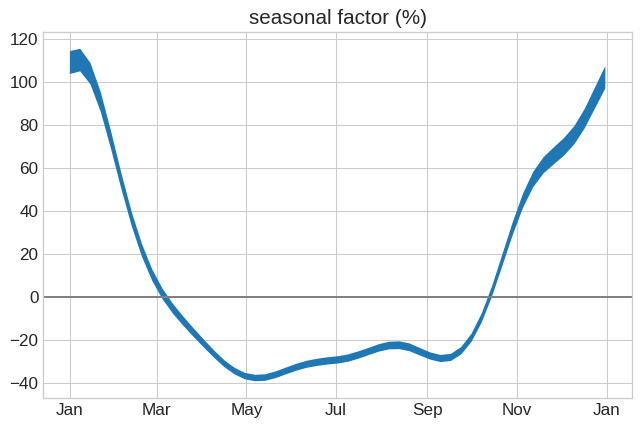

In [12]:
plt.figure(figsize=(8, 5))

tmp = (az.hdi(trd.seasonal_factor.to_numpy().T).T - 1)*100
plt.fill_between([date(2021, 1, 1) + timedelta(i*7) for i in range(53)],
                 tmp[0], tmp[1])
plt.axhline(0, color='gray')
plt.gca().xaxis.set_major_formatter(DateFormatter('%b'))
plt.gca().set(title='seasonal factor (%)')
None

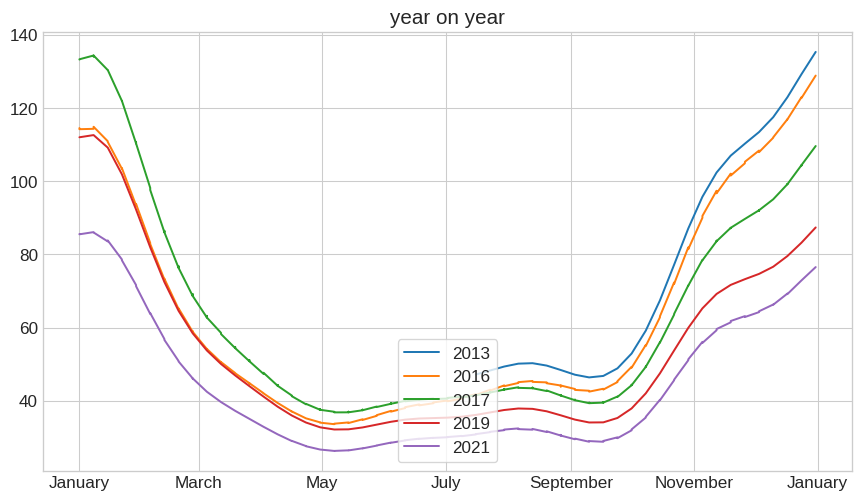

In [13]:
tmp_dates = data[['time', 'woy', 'week']].drop_duplicates().sort_values('time')
tmp = np.mean(
    np.exp(
        4
        + trd.a.to_numpy()[tmp_dates.week]
        + trd.s.to_numpy()[tmp_dates.woy]
        + trd.rho.to_numpy().reshape(1, -1) ** 2 / 2
    ),
    axis=1
)
tmp = pd.Series(tmp, name='yoy_mean').to_frame().join(tmp_dates.reset_index(drop=True))
tmp = tmp.assign(
    year = tmp.time.dt.year,
    day_index = tmp.woy.map(lambda i: date(2021, 1, 1) + timedelta(7*i))
)

plt.figure(figsize=(11, 6))

for i in [2013, 2016, 2017, 2019, 2021]:
    tmp_y = tmp[tmp.year == i].sort_values('woy')
    plt.plot(tmp_y.day_index, tmp_y.yoy_mean, label=i)

plt.gca().set(title='year on year', xlabel='')
plt.gca().xaxis.set_major_formatter(DateFormatter('%B'))
plt.legend(loc='lower center', frameon=True)
None

---